# Devoir Python

Vous devez rendre votre devoir sur GitHub.
Vous avez le droit a tout vos documents et a internet

1. votre depot doit etre privé
2. vous devez inviter comme colaborateur votre chargé de TD/TP
3. Seul le dernier commit avant la fin de la séance sera corrigé.


Ex 1: Integrale de Romberg

Ecrire une fonction integ_romberg(f, a, b, epsilon=1e-6) permettant de calculer l’intégrale numérique de la fonction f entre les bornes a et b avec une précision epsilon selon la méthode de Romberg (https://fr.wikipedia.org/wiki/M%C3%A9thode_de_Romberg).

Il s’agit d’une méthode qui permet d’améliorer les méthodes usuelles de calcul numérique des intégrales, comme la méthode des Trapèzes.
On montre qu’en combinant judicieusement les valeurs obtenues par la méthode des Trapèzes pour différentes subdivisons de l’intervalle d’intégration, on augmente l’ordre de convergence (sa vitesse de convergence). 


In [1]:
import numpy as np
import matplotlib.pyplot as plt


def f(x):
   f = np.exp(-x*x)
   return f;


# régle pour le trapèze
def trapezoid(f,a,b,N):
    h   = (b-a)/N
    xi  = np.linspace(a,b,N+1)
    fi  = f(xi)
    s   = 0.0
    for i in range(1,N):
        s = s + fi[i]
    s = (h/2)*(fi[0] + fi[N]) + h*s
    return s

# la fonction romberg
def integ_romberg(f,a,b,eps,nmax):
# f     ... la fonction à intégré
# [a,b] ... intervalle de l'intégration
# eps   ... desired accuracy
# nmax  ... nmax pour la methode de Romberg
    Q         = np.zeros((nmax,nmax),float)
    converged = 0
    for i in range(0,nmax):
        N      = 2**i
        Q[i,0] = trapezoid(f,a,b,N)
        for k in range(0,i):
            n        = k + 2
            Q[i,k+1] = 1.0/(4**(n-1)-1)*(4**(n-1)*Q[i,k] - Q[i-1,k])
        if (i > 0):
            if (abs(Q[i,k+1] - Q[i,k]) < eps):
               converged = 1
               break
    print(Q[i,k+1],N,converged)   
    return Q[i,k+1],N,converged

# programme dans le main
a  = 0.0;b = 1.0  # intervalle d'intégration[a,b]
integ_romberg(f,a,b,1e-6,10)


0.7468240184822817 8 1


(0.7468240184822817, 8, 1)

Ex 2: Équation d’état de l’eau à partir de la dynamique moléculaire

Afin de modéliser les planètes de type Jupiter, Saturne, ou même des exo-planètes très massives (dites « super-Jupiters »), la connaissance de l’équation d’état des composants est nécessaire. Ces équations d’état doivent être valables jusqu’à plusieurs centaines de méga-bar ; autrement dit, celles-ci ne sont en aucun cas accessibles expérimentalement. On peut cependant obtenir une équation d’état numériquement à partir d’une dynamique moléculaire.

Le principe est le suivant : on place dans une boite un certain nombre de particules régies par les équations microscopiques (Newton par exemple, ou même par des équations prenant en considération la mécanique quantique) puis on laisse celles-ci évoluer dans la boite ; on calcule à chaque pas de temps l’énergie interne à partir des intéractions électrostatiques et la pression à partir du tenseur des contraintes. On obtient en sortie l’évolution du système pour une densité fixée (par le choix de taille de la boite) et une température fixée (par un algorithme de thermostat que nous ne détaillerons pas ici).

On se propose d’analyser quelques fichiers de sortie de tels calculs pour l’équation d’état de l’eau à très haute pression. Les fichiers de sortie sont disponibles ici; leur nom indique les conditions thermodynamiques correspondant au fichier, p.ex. 6000K_30gcc.out pour T=6000
K et ρ=30 gcc. Le but est, pour chaque condition température-densité, d’extraire l’évolution de l’énergie et de la pression au cours du temps, puis d’en extraire la valeur moyenne ainsi que les fluctuations. Il arrive souvent que l’état initial choisi pour le système ne corresponde pas à son état d’équilibre, et qu’il faille donc « jeter » les quelques pas de temps en début de simulation qui correspondent à cette relaxation du système. Pour savoir combien de temps prend cette relaxation, il sera utile de tracer l’évolution au cours du temps de la pression et l’énergie pour quelques simulations. Une fois l’équation d’état P(ρ,T) et E(ρ,T) extraite, on pourra tracer le réseau d’isothermes.

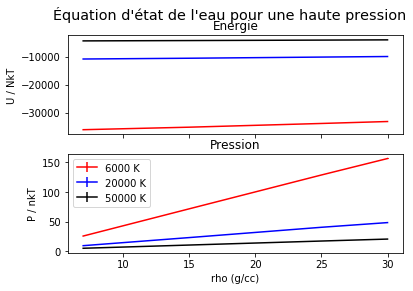

In [4]:

#Équation d’état de l’eau

import numpy as N
import matplotlib.pyplot as P

import pytest                    # pytest importe pour les tests unitaires

"""
Construction d'un système d'extraction et d'analyse de fichiers de sortie de
dynamique moléculaire afin d'extraire les grandeurs thermodynamiques.
On affichera les ensuite isothermes.
"""

__author__ = "Adrien Licari <adrien.licari@ens-lyon.fr>"


tolerance = 1e-8  # Un seuil de tolérance pour les égalités sur réels


#Partie simulation#


class Simulation:
    """
    La classe Simulation représente une simulation de dynamique
    moléculaire, donc un point de l'équation d'état. Son constructeur
    doit impérativement être appelé avec le chemin du fichier output
    correspondant. Elle possède des méthodes pour extraire les grandeurs
    thermodynamiques et afficher la run, en pouvant enlever certains pas
    de temps en début de simulation.
    """

    def __init__(self, temp, dens, path):
        """
        Le constructeur doit impérativement être appelé avec le chemin du
        fichier décrivant la simulation, ainsi que ses conditions
        thermodynamiques.

        Args :
                temp,dens(float): La température et la densité de la simulation
                path(string): Le chemin vers le fichier décrivant la simulation

        Raises :
                TypeError si temp ou dens ne sont pas des réels
                IOError si le fichier n'existe pas
        """
        self.temp = float(temp)
        self.dens = float(dens)
        tmp = N.loadtxt(path, skiprows=1).T
        self.pot = tmp[0]
        self.kin = tmp[1]
        self.tot = self.pot + self.kin
        self.press = tmp[2]

    def __str__(self):
        """
        Surcharge de l'opérateur str.
        """
        return "Simulation at {:.0f} g/cc and {:.0f} K ; {:d} timesteps". \
            format(self.dens, self.temp, len(self.pot))

    def thermo(self, skipSteps=0):
        """
        Calcule l'énergie et la pression moyenne au cours de la simulation.
        Renvoie un dictionnaire.

        Args:
                skipSteps(int): Représente le nombre de pas à enlever en début de simulation.

        Returns:
                {'T':temperature, 'rho':density,
                 'E':energy, 'P':pressure,
                 'dE':dEnergy, 'dP':dPressure}
        """
        return {'T': self.temp,
                'rho': self.dens,
                'E': self.tot[skipSteps:].mean(),
                'P': self.press[skipSteps:].mean(),
                'dE': self.tot[skipSteps:].std(),
                'dP': self.press[skipSteps:].std()}

    def plot(self, skipSteps=0):
        """
        Affiche l'évolution de la Pression et de l'énergie interne au cours de
        la simulation.

        Args:
                skipSteps(int): Pas de temps à enelevr en début de simulation.

        Raises:
                TypeError si skipSteps n'est pas un entier.
        """
        fig, (axen, axpress) = P.subplots(2, sharex=True)
        axen.plot(list(range(skipSteps, len(self.tot))), self.tot[skipSteps:],
                  'rd--')
        axen.set_title("Internal energy (Ha)")
        axpress.plot(list(range(skipSteps, len(self.press))), self.press[skipSteps:],
                     'rd--')
        axpress.set_title("Pressure (GPa)")
        axpress.set_xlabel("Timesteps")

        P.show()

##### Tests pour Simulation #####


def mimic_simulation(filename):
    with open(filename, 'w') as f:
        f.write("""Potential energy (Ha)	Kinetic Energy (Ha)	Pressure (GPa)
-668.2463567264        	0.7755612311   		9287.7370229824
-668.2118514558        	0.7755612311		9286.1395903265
-668.3119088218        	0.7755612311		9247.6604398856
-668.4762735176        	0.7755612311		9191.8574820856
-668.4762735176        	0.7755612311		9191.8574820856
""")


def test_Simulation_init():
    mimic_simulation("equationEtat_simuTest.out")
    s = Simulation(10, 10, "equationEtat_simuTest.out")
    assert len(s.kin) == 5
    assert abs(s.kin[2] - 0.7755612311) < tolerance
    assert abs(s.pot[1] + 668.2118514558) < tolerance


def test_Simulation_str():
    mimic_simulation("equationEtat_simuTest.out")
    s = Simulation(10, 20, "equationEtat_simuTest.out")
    assert str(s) == "Simulation at 20 g/cc and 10 K ; 5 timesteps"


def test_Simulation_thermo():
    mimic_simulation("equationEtat_simuTest.out")
    s = Simulation(10, 20, "equationEtat_simuTest.out")
    assert abs(s.thermo()['T'] - 10) < tolerance
    assert abs(s.thermo()['rho'] - 20) < tolerance
    assert abs(s.thermo()['E'] + 667.56897157674) < tolerance
    assert abs(s.thermo()['P'] - 9241.0504034731) < tolerance
    assert abs(s.thermo(3)['E'] + 667.7007122865) < tolerance
    assert abs(s.thermo(3)['P'] - 9191.8574820856) < tolerance

###################
### Main script ###
###################

if __name__ == '__main__':
    """
    On définit un certain nombre de pas de temps à sauter, puis on
    charge chaque simulation et extrait les informaions thermodynamiques
    associées. On affiche enfin les isothermes normalisées (E/NkT et P/nkT).
    """

    ### Definitions ###
    a0 = 0.52918      # Bohr radius in angstrom
    amu = 1.6605      # atomic mass unit in e-24 g
    k_B = 3.16681e-6  # Boltzmann's constant in Ha/K
    # normalization factor for P/nkT
    nk_GPa = a0 ** 3 * k_B * 2.942e4 / 6 / amu
    nsteps = 200  # define skipped timesteps (should be done for
    # each simulation...)
    temps = [6000, 20000, 50000]    # define temperatures
    colors = {6000: 'r', 20000: 'b', 50000: 'k'}
    denss = [7, 15, 25, 30]  # define densities
    keys = ['T', 'rho', 'E', 'dE', 'P', 'dP']
    eos = dict.fromkeys(keys, N.zeros(0))   # {key:[]}

    ### Extract the EOS out of the source files ###
    for t, rho in [(t, rho) for t in temps for rho in denss]:
        filenm = "outputs/{}K_{:0>2d}gcc.out".format(t, rho)
        s = Simulation(t, rho, filenm)
        for key in keys:
            eos[key] = N.append(eos[key], s.thermo(nsteps)[key])

    ### Plot isotherms ###
    fig, (axen, axpress) = P.subplots(2, sharex=True)
    fig.suptitle("Équation d'état de l'eau pour une haute pression", size='x-large')
    axen.set_title("Energie")
    axen.set_ylabel("U / NkT")
    axpress.set_title("Pression")
    axpress.set_ylabel("P / nkT")
    axpress.set_xlabel("rho (g/cc)")
    for t in temps:
        sel = eos['T'] == t
        axen.errorbar(x=eos['rho'][sel], y=eos['E'][sel] / k_B / t,
                      yerr=eos['dE'][sel] / k_B / t, fmt=colors[t] + '-')
        axpress.errorbar(x=eos['rho'][sel],
                         y=eos['P'][sel] / eos['rho'][sel] / nk_GPa / t,
                         yerr=eos['dP'][sel] / eos['rho'][sel] / nk_GPa / t,
                         fmt=colors[t] + '-',
                         label="{} K".format(t))
    axpress.legend(loc='best')
    P.show()

Ex 3: Le problème du voyageur de commerce

Le problème du voyageur de commerce est un problème d’optimisation consistant à déterminer le plus court chemin reliant un ensemble de destinations. Il n’existe pas d’algorithme donnant la solution optimale en un temps raisonnable (problème NP-complet), mais l’on peut chercher à déterminer des solutions approchées. On va se placer ici dans le cas d’un livreur devant desservir une seule fois chacune desndestinations d’une ville américaine où les rues sont agencées en réseau carré. 

On utilise la « distance deManhattan »  entre deux points 𝐴(𝑥𝐴,𝑦𝐴) et 𝐵(𝑥𝐵,𝑦𝐵) : 𝑑(𝐴,𝐵) =|𝑥𝐵−𝑥𝐴|+|𝑦𝐵−𝑦𝐴|.

En outre, on se place dans le cas où les coordonnées des destinations sont entières, comprises entre 0 (inclus) et TAILLE = 50 (exclus). Deux destinations peuvent éventuellement avoir les mêmes coordonnées. Les instructions suivantes doivent permettre de définir les classes nécessaires (Ville et Trajet) et de développer un algorithme approché (heuristiques) : l’algorithme du plus proche voisin. 

Seules la librairie standard et la librairie numpy sont utilisables si nécessaire. Implementer les classes et methodes suivante:


Classe Ville:
* __init__(): initialisation d’une ville sans destination.
* aleatoire(n): création de n destinations aléatoires.
* nb_trajet(): retourne le nombre total (entier) de trajets :(𝑛−1)!/2(utilisermath.factorial()).
* distance(i, j): retourne la distance (Manhattan) entre les deux destinations de numéro i et j


Classe Trajet:
* __init__(ville, etapes=None): initialisation sur une ville. Si la liste etapes n’est pas spécifiée, le trajet par défaut est celui suivant les destinations de ville.
* longueur(): retourne la longueur totale du trajetbouclé(i.e. revenant à son point de départ).


Plus proche voisin:
* Ville.plus_proche(i, exclus=[]): retourne la destination la plus proche de la destinationi(au sens de Ville.distance()), hors les destinations de la liste exclus
* Ville.trajet_voisins(depart=0): retourne un Trajet déterminé selon l’heuristique des plus proches voisins (i.e. l’étape suivante est la destination la plus proche hors les destinations déjà visitées) en partant de l’étape initiale depart

Optimisation:
* Proposer un algorithme qui propose une meilleur alternative au "plus proche voisin".

Interface:
* Ville.figure(trajet=None): Afficher le plande la ville et le trajet obtenue (utiliser matplotlib.step()pour des trajets de type « Manhattan »)

NameError: name 'x' is not defined

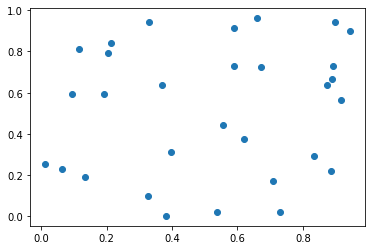

In [1]:
# Exercice3
import random
n = 30
x = [ random.random() for _ in range(n) ]
y = [ random.random() for _ in range(n) ]
import matplotlib.pyplot as plt
plt.plot(x,y,"o")

longueur initiale 14.125477380749311
iteration 2 d= 14.125477380749311
iteration 3 d= 2.7178639057655705
iteration 4 d= 1.4483955761246405
iteration 5 d= 1.0133347056566175
iteration 6 d= 0.9813178265619666
iteration 7 d= 0.9690909264280948
longueur min 0.9690909264280948


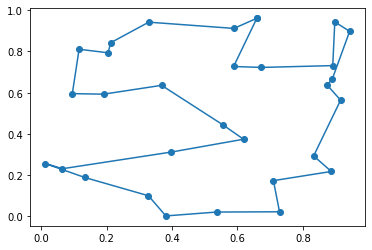

In [2]:
def longueur (x,y, ordre):
    i = ordre[-1]
    x0,y0 = x[i], y[i]
    d = 0
    for o in ordre:
        x1,y1 = x[o], y[o]
        d += (x0-x1)**2 + (y0-y1)**2
        x0,y0 = x1,y1
    return d

ordre = list(range(len(x)))
print("longueur initiale", longueur(x,y,ordre))

def permutation(x,y,ordre):
    d  = longueur(x,y,ordre)
    d0 = d+1
    it = 1
    while d < d0 :
        it += 1
        print("iteration",it, "d=",d)
        d0 = d
        for i in range(0,len(ordre)-1) :
            for j in range(i+2,len(ordre)):
                r = ordre[i:j].copy()
                r.reverse()
                ordre2 = ordre[:i] + r + ordre[j:]
                t = longueur(x,y,ordre2)
                if t < d :
                    d = t
                    ordre = ordre2
    return ordre

ordre = permutation (x,y,list(range(len(x))))
print("longueur min", longueur(x,y,ordre))
xo = [ x[o] for o in ordre + [ordre[0]]]
yo = [ y[o] for o in ordre + [ordre[0]]]
plt.plot(xo,yo, "o-")

longueur initiale 13.775943226240377
iteration 2 d= 13.775943226240377
iteration 3 d= 1.5118987174953564
iteration 4 d= 0.9307753187717464
iteration 5 d= 0.7873457316916294
longueur min 0.7873457316916294


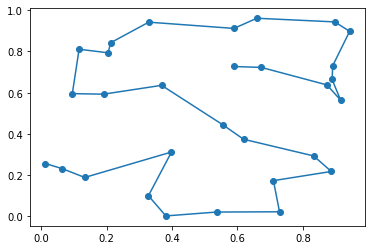

In [3]:
def longueur (x,y, ordre):
   
    d = 0
    for i in range(1,len(ordre)):
        n = ordre[i-1]
        o = ordre[i]
        x0,y0 = x[n], y[n]
        x1,y1 = x[o], y[o]
        d += (x0-x1)**2 + (y0-y1)**2
    return d

ordre = list(range(len(x)))
print("longueur initiale", longueur(x,y,ordre))

ordre = permutation (x,y,list(range(len(x))))
print("longueur min", longueur(x,y,ordre))
xo = [ x[o] for o in ordre]
yo = [ y[o] for o in ordre]
plt.plot(xo,yo, "o-")

longueur initiale 0.7873457316916294
iteration 0 d= 13.775943226240377
iteration 1 d= 1.0127490251320883
iteration 2 d= 0.8685081435840512
iteration 3 d= 0.8685081435840512
iteration 4 d= 0.8685081435840512
iteration 5 d= 0.8685081435840512
iteration 6 d= 0.8685081435840512
iteration 7 d= 0.8685081435840512
iteration 8 d= 0.8685081435840512
iteration 9 d= 0.8685081435840512
iteration 10 d= 0.8507573310668517
iteration 11 d= 0.8507573310668517
iteration 12 d= 0.8507573310668517
iteration 13 d= 0.8277528981265141
iteration 14 d= 0.8277528981265141
iteration 15 d= 0.8277528981265141
iteration 16 d= 0.8277528981265141
iteration 17 d= 0.8277528981265141
iteration 18 d= 0.8277528981265141
iteration 19 d= 0.8277528981265141
longueur min 0.8277528981265141


Text(0.5882448003436516, 0.7264553128920406, 'N-1')

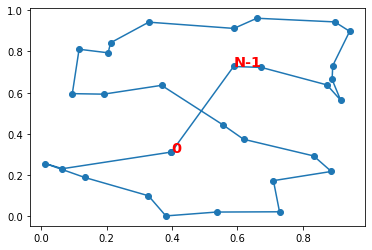

In [4]:
print("longueur initiale", longueur(x,y,ordre))

def permutation_rnd(x,y,ordre,miniter):
    d  = longueur(x,y,ordre)
    d0 = d+1
    it = 1
    while d < d0 or it < miniter :
        it += 1
        d0 = d
        for i in range(1,len(ordre)-1) :
            for j in range(i+2,len(ordre)+ 1):
                k = random.randint(1,len(ordre)-1)
                l = random.randint(k+1,len(ordre))
                r = ordre[k:l].copy()
                r.reverse()
                ordre2 = ordre[:k] + r + ordre[l:]
                t = longueur(x,y,ordre2)
                if t < d :
                    d = t
                    ordre = ordre2
    return ordre

def n_permutation(x,y, miniter):
    ordre = list(range(len(x)))
    bordre = ordre.copy()
    d0 = longueur(x,y,ordre)
    for i in range(0,20):
        print("iteration",i, "d=",d0)
        random.shuffle(ordre)
        ordre = permutation_rnd (x,y,ordre, 20)
        d = longueur(x,y,ordre)
        if d < d0 :
            d0 = d
            bordre = ordre.copy()
    return bordre

ordre = n_permutation (x,y, 20)
print("longueur min", longueur(x,y,ordre))
xo = [ x[o] for o in ordre + [ordre[0]]]
yo = [ y[o] for o in ordre + [ordre[0]]]
plt.plot(xo,yo, "o-")
plt.text(xo[0],yo[0],"0",color="r",weight="bold",size="x-large")
plt.text(xo[-2],yo[-2],"N-1",color="r",weight="bold",size="x-large")